In [1]:
import re
from copy import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import matplotlib.colors

plt.rcParams["figure.figsize"] = (10,8)

In [2]:
raw = pd.read_csv("input/IV_CAT v4.csv")
raw

,Tool ID,In SR or is Standalone?,1st Level Code,2nd Level Code,3rd Level Code,4th Level Code,Normalised Criterion,Appraisal (A) or Reporting (R) Mode,"Original, Modified or Existing tool?",Eligibility of Parent Tool?,Web of Science Topic Label 1,Web of Science Topic Label 2,Web of Science Topic Label 3,Web of Science Topic Label 4,Web of Science Topic Label 5
0,Adnan 2018,Systematic review,Analysis,Results,Complete reporting,Not classified,Selective reporting,A,Original,NaN,Dentistry,Oral surgery and medicine,NaN,NaN,NaN
1,Adnan 2018,Systematic review,Test System,Experimental Practice,Controlling for systematic error,Allocation concealment,Allocation concealment,A,Original,NaN,Dentistry,Oral surgery and medicine,NaN,NaN,NaN
2,Adnan 2018,Systematic review,Test System,Experimental Practice,Controlling for systematic error,Blinding,Blinded outcome assessment,A,Original,NaN,Dentistry,Oral surgery and medicine,NaN,NaN,NaN
3,Adnan 2018,Systematic review,Test System,Experimental Practice,Controlling for systematic error,Randomisation,Random allocation of subjects to study groups,A,Original,NaN,Dentistry,Oral surgery and medicine,NaN,NaN,NaN
4,Altmann 2016,Systematic review,Test System,Experimental Practice,Controlling for systematic error,Randomisation,Randomisation of teeth,R,Unclear,NaN,Dentistry,Oral surgery and medicine,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,Yosupov 2017,Systematic review,Test System,Experimental Practice,Controlling for systematic error,Attrition,Study subject attrition rates,A,Existing,Ineligible,NaN,NaN,NaN,NaN,NaN
982,Yosupov 2017,Systematic review,Test System,Experimental Practice,Controlling for systematic error,Blinding,Blinded outcome assessment,A,Existing,Ineligible,NaN,NaN,NaN,NaN,NaN
983,Yosupov 2017,Systematic review,Test System,Experimental Practice,Controlling for systematic error,Not classified,Identical experimental conditions across study...,A,Existing,Ineligible,NaN,NaN,NaN,NaN,NaN
984,Yosupov 2017,Systematic review,Test System,Experimental Practice,Controlling for systematic error,Not classified,Other sources of bias,A,Existing,Ineligible,NaN,NaN,NaN,NaN,NaN


In [3]:
# Extract year
def get_year(string):
    match = re.findall(r"\d\d\d\d", string)
    #print(f" => {match}")
    return int(match[0])

def contains_a(string):
    return 'A' in string

def contains_r(string):
    return 'R' in string

# Remove any trailing colons
def remove_trailing_colons(string):
    return string.rstrip(":")

def remove_dangling_not_classified(string):
    return re.sub(r'(Not classified:?)+', 'Not classified', string)

raw['year'] = raw['Tool ID'].apply(get_year)
raw['A'] = raw['Appraisal (A) or Reporting (R) Mode'].apply(contains_a)
raw['R'] = raw['Appraisal (A) or Reporting (R) Mode'].apply(contains_r)


# Unify Headings for the same reason
t = raw.fillna('')
t = raw.replace("Not applicable", "")
raw['Heading']    = (t['1st Level Code'] + ":" + t['2nd Level Code'] + ":" + t['3rd Level Code'] + ":" + t['4th Level Code']).apply(remove_dangling_not_classified).apply(remove_trailing_colons)
raw['Heading_1']  = (t['1st Level Code']).apply(remove_dangling_not_classified).apply(remove_trailing_colons)
raw['Heading_12'] = (t['1st Level Code'] + ":" + t['2nd Level Code']).apply(remove_dangling_not_classified).apply(remove_trailing_colons)
raw['Heading_123'] = (t['1st Level Code'] + ":" + t['2nd Level Code'] + ":" + t['3rd Level Code']).apply(remove_dangling_not_classified).apply(remove_trailing_colons)


raw['Heading'].unique()

array(['Analysis:Results:Complete reporting:Not classified',
       'Test System:Experimental Practice:Controlling for systematic error:Allocation concealment',
       'Test System:Experimental Practice:Controlling for systematic error:Blinding',
       'Test System:Experimental Practice:Controlling for systematic error:Randomisation',
       'Test System:Experimental Practice:Not classified',
       'Test System:Theory:Methodological Information:Not classified',
       'Analysis:Interpretation:Not classified',
       'Analysis:Results:Not classified',
       'Analysis:Results:Statistical methods:Not classified',
       'Objective:Hypothesis:Theoretical basis:Not classified',
       'Objective:Justification:Context:Not classified',
       'Objective:Not classified', 'Other:Interests:Not classified',
       'Test System:Theory:Not classified',
       'Test System:Theory:PECO:Outcomes',
       'Test System:Experimental Practice:Controlling for random error:Sample size',
       'Test Syst

## Tool-wise
Here we refactor the data to talk about each _tool_, and the features within.  Since criteria are not independent, this is the level we should do most associations.

In [4]:
def append_colwise(columnwise, rowwise_dict):
    for k, v in rowwise_dict.items():
        if k not in columnwise:
            columnwise[k] = []
        columnwise[k].append(v)
        
columnwise_data = {'Tool ID': raw['Tool ID'].unique()}
for tool_id in columnwise_data['Tool ID']:
    #print(tool_id)
    
    heading_counts = {f"heading_{x}": 0 for x in raw['Heading'].unique()}
    criterion_counts = {f"criterion_{x}": 0 for x in raw['Normalised Criterion'].unique()}
    eligibility_counts = {f"eligibility_{x}": 0 for x in raw['Eligibility of Parent Tool?'].unique()}
    ar_count = {'A': 0, 'R': 0}
    unique_counts = {'count_unique_headings': 0,
                     'count_unique_headings_12': 0,
                     'count_unique_topics': 0,
                     'count_unique_criteria': 0,
                     'count_unique_eligibility': 0
                    }
    year = None
    is_sr = None
    num_criteria = 0
    
    # Read data from the per-criterion data
    # sd == 'study data', but shorter for typing laziness.
    sd = raw[raw['Tool ID'] == tool_id]
    
    # Count up instances of each thing for this tool
    for _, sdr in sd.iterrows():
        #print(f" -> {sdr['year']}")
        heading_counts[f"heading_{sdr['Heading']}"] += 1
        criterion_counts[f"criterion_{sdr['Normalised Criterion']}"] += 1
        eligibility_counts[f"eligibility_{sdr['Eligibility of Parent Tool?']}"] += 1
        year = sdr['year']
        is_sr = sdr['In SR or is Standalone?'] == "Systematic review"
    unique_counts['count_unique_headings'] = len(sd['Heading'].unique())
    unique_counts['count_unique_headings_12'] = len(sd['Heading_12'].unique())
    unique_counts['count_unique_criteria'] = len(sd['Normalised Criterion'].unique())
    unique_counts['count_unique_eligibility'] = len(sd['Eligibility of Parent Tool?'].unique())
    ar_count = {'A': sum(sd['A']), 'R': sum(sd['R'])}
    num_criteria = sd.shape[0]
    
    append_colwise(columnwise_data, heading_counts)
    append_colwise(columnwise_data, criterion_counts)
    append_colwise(columnwise_data, eligibility_counts)
    append_colwise(columnwise_data, ar_count)
    append_colwise(columnwise_data, unique_counts)
    append_colwise(columnwise_data, {'year': year})
    append_colwise(columnwise_data, {'num_criteria': num_criteria})
    append_colwise(columnwise_data, {'is_sr': is_sr})

tools = pd.DataFrame(columnwise_data, index=columnwise_data['Tool ID'])    
tools['is_sr_numeric'] = tools['is_sr'].astype('int')

tools

,Tool ID,heading_Analysis:Results:Complete reporting:Not classified,heading_Test System:Experimental Practice:Controlling for systematic error:Allocation concealment,heading_Test System:Experimental Practice:Controlling for systematic error:Blinding,heading_Test System:Experimental Practice:Controlling for systematic error:Randomisation,heading_Test System:Experimental Practice:Not classified,heading_Test System:Theory:Methodological Information:Not classified,heading_Analysis:Interpretation:Not classified,heading_Analysis:Results:Not classified,heading_Analysis:Results:Statistical methods:Not classified,...,R,count_unique_headings,count_unique_headings_12,count_unique_topics,count_unique_criteria,count_unique_eligibility,year,num_criteria,is_sr,is_sr_numeric
Adnan 2018,Adnan 2018,1,1,1,1,0,0,0,0,0,...,0,4,2,0,4,1,2018,4,True,1
Altmann 2016,Altmann 2016,0,0,0,1,3,6,0,0,0,...,10,3,2,0,10,1,2016,10,True,1
Asweto 2017,Asweto 2017,0,0,0,0,0,1,1,1,3,...,10,10,7,0,12,1,2017,12,True,1
Aurelio 2016,Aurelio 2016,0,0,1,1,0,0,0,0,0,...,9,6,1,0,9,1,2016,9,True,1
Benetti 2018,Benetti 2018,0,0,1,0,0,2,0,0,1,...,8,7,4,0,8,1,2018,8,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Verhagen 2003,Verhagen 2003,0,0,0,0,1,0,0,0,1,...,0,12,5,0,15,1,2003,15,False,0
Vesterinen 2011,Vesterinen 2011,0,1,1,1,0,1,0,1,6,...,22,17,7,0,26,1,2011,26,True,1
Xu 2017,Xu 2017,0,0,0,0,0,0,0,1,1,...,0,10,8,0,15,1,2017,15,True,1
Yaylali 2013,Yaylali 2013,1,1,2,1,0,0,0,0,0,...,0,9,3,0,11,1,2013,11,True,1


# Cumulative Categories
How the individual categories have accumulated over time.

Hsie 1981,13
Harbell 1997,7
Klimisch 1997,1
Richardson 2003,7
Verhagen 2003,2
Goode 2008,4
Lovell 2008,1
Murdock 2009,0
Schneider 2009,1
Kantovitz 2010,0
Ntrouka 2010,1
Elmer 2011,1
Louropoulou 2011,0
Vesterinen 2011,4
Liu 2013,0
Twetman 2013,1
Yaylali 2013,1
Goldman 2014,0
Louropoulou 2014,0
McConnell 2014,3
Montagner 2014,0
Sarkis-Onofre 2014,0
van Holder 2014,0
Golbach 2015,0
Kesselheim 2015,0
Lenzi 2015,0
Martin 2015,0
Pavan 2015,0
Ramamoorthi 2015,3
Scholes 2015,1
Simko 2015,0
Altmann 2016,0
Aurelio 2016,0
Brouwer 2016,0
Buhler 2016,1
Cell Press 2016,1
Cramond 2016,1
Gorman 2016,0
Masarwa 2016,0
Rahman 2016,1
Sedrez-Porto 2016,0
Simko 2016,0
Tsirogiannis 2016,1
Asweto 2017,1
Chan 2017,0
Collins 2017,0
Ferrua 2017,0
Mozynska 2017,0
Pronin 2017,0
Rego 2017,0
Runkle 2017,1
Santos 2017,0
Xu 2017,1
Yosupov 2017,0
Adnan 2018,0
Benetti 2018,0
Fernandez-Cruz 2018,1
Fliefel 2018,0
Kaczor 2018,0
Martins 2018,0
Munchow 2018,0
Osmanovic 2018,0
Rojo 2018,0
Romaneli 2018,0
Teixeira 2018,0
Teixe

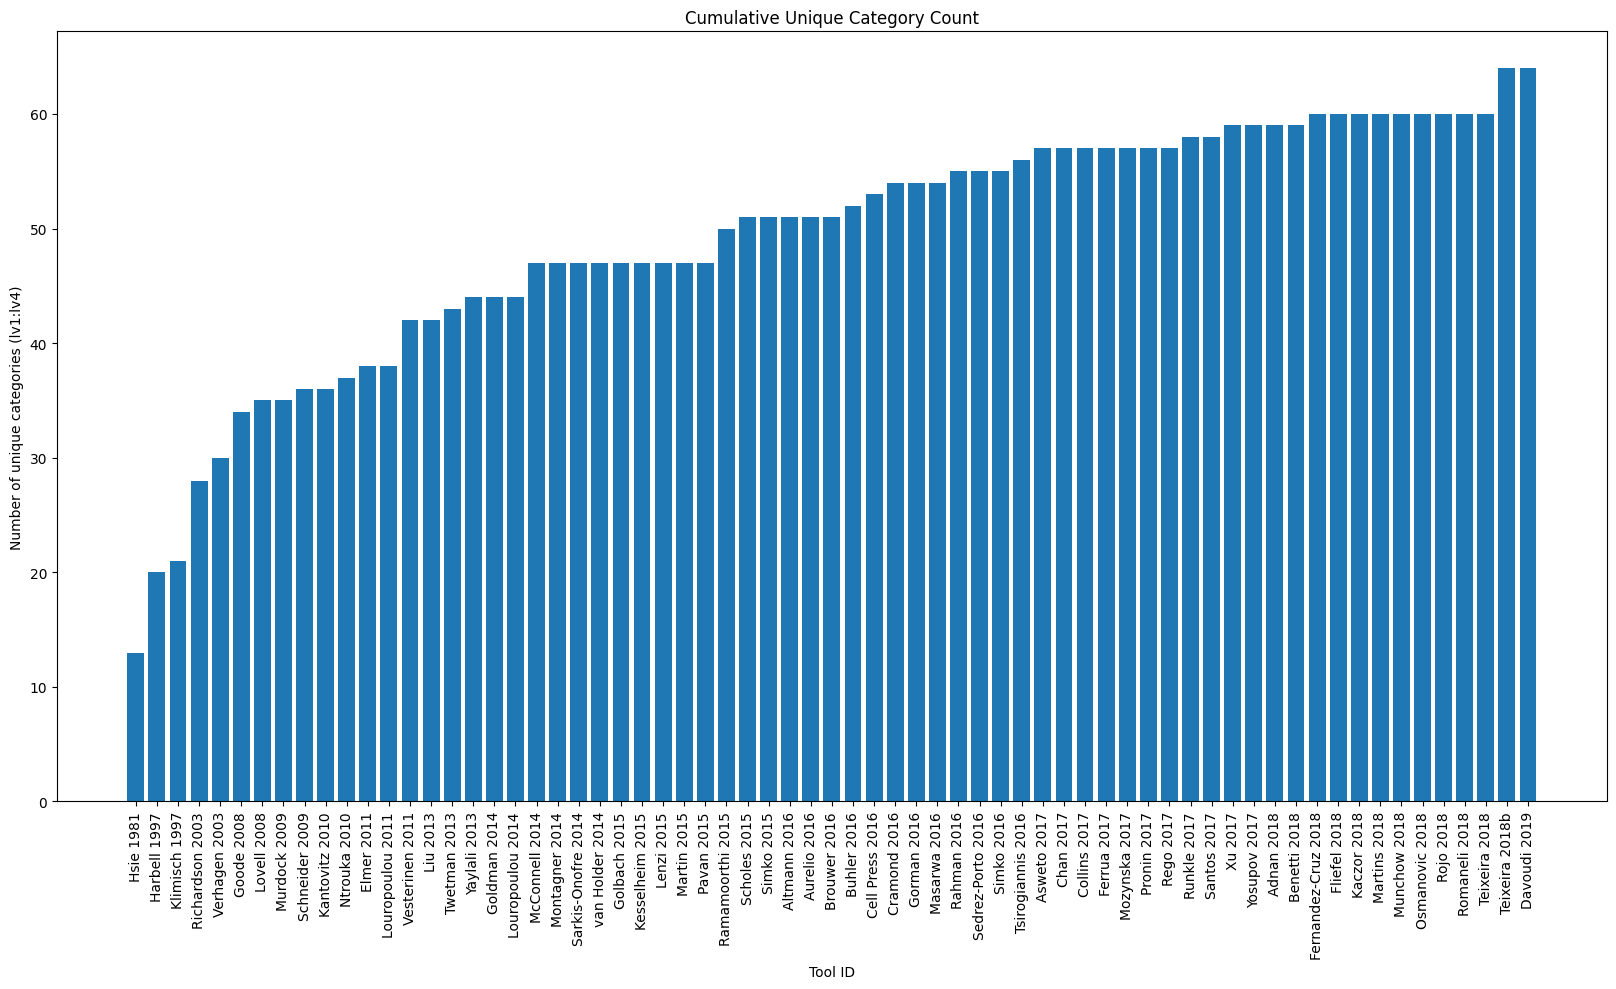

In [6]:
# Get a list of the individual studies, sorted by the year of publication



tools_sorted_by_year = tools.sort_values(["year", "Tool ID"])

unseen_count_by_study = []
unseen_by_study = []
seen_categories = set()
for tool_id in tools_sorted_by_year['Tool ID'].unique():
    #print(f"-> {tool_id}")

    tool_info = tools[tools["Tool ID"] == "Hsie 1981"]
    criteria = raw[raw["Tool ID"] == tool_id]

    new_categories = set()
    for criterion in criteria.iterrows():

        category = criterion[1][18]
        # print(f"-> {category}")
        if category not in seen_categories:
            new_categories.add(category)

    unseen_count_by_study.append(len(new_categories))
    unseen_by_study.append(new_categories)
    seen_categories = seen_categories.union(new_categories)

    print(f"{tool_id},{len(new_categories)}")

#    print(f"\n{tool_id}")
#    print("  " + '\n  '.join([str(x) for x in new_categories]))


cumulative_unseen_count_by_study = [sum(unseen_count_by_study[:i+1]) for i in range(len(unseen_count_by_study))]

# ----------------------------------------------------


plt.rcParams["figure.figsize"] = (20,10)
plt.bar(tools_sorted_by_year['Tool ID'].unique(), cumulative_unseen_count_by_study)
plt.title("Cumulative Unique Category Count")
plt.ylabel("Number of unique categories (lv1:lv4)")
plt.xlabel("Tool ID")
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = (10,8)


## Figure 1

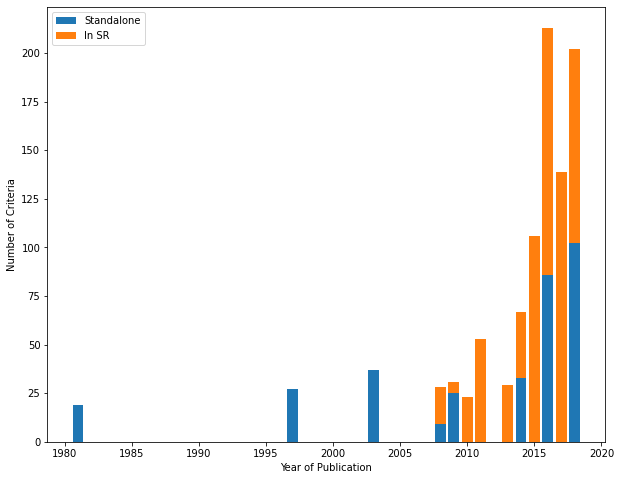

In [5]:
#years_in_dataset = raw['year'].unique()


in_sr = raw['In SR or is Standalone?'] == "Systematic review"
standalone = raw['In SR or is Standalone?'] == "Standalone"

years = list(range(min(raw['year']), max(raw['year'])))
in_sr_counts = [0] * len(years)
standalone_counts = [0] * len(years)
for i, y in enumerate(years):
    
    if y in raw[in_sr]['year'].value_counts():
        in_sr_counts[i] = raw[in_sr]['year'].value_counts()[y]
    else:
        in_sr_counts[i] = 0
        
    if y in raw[standalone]['year'].value_counts():
        standalone_counts[i] = raw[standalone]['year'].value_counts()[y]
    else:
        standalone_counts[i] = 0
        

b1 = plt.bar(years, standalone_counts)
b2 = plt.bar(years, in_sr_counts, bottom=standalone_counts)

plt.xlabel("Year of Publication")
plt.ylabel("Number of Criteria")
plt.legend((b1, b2), ("Standalone", "In SR"))

#plt.bar(raw[in_sr]['year'].unique(), raw[in_sr]['year'].value_counts())




#plt.bar(raw[in_sr]['year'].unique(), raw[raw[in_sr]]['year'].value_counts())
#plt.title("Criteria Introduced by Year (reviews)")
#plt.show()
#plt.bar(raw[raw['In SR or is Standalone?'] == False]['year'].unique(), raw[raw['In SR or is Standalone?'] == False]['year'].value_counts())
#plt.title("Criteria Introduced by Year (tools)")

## Figure 2
Box plot of counts for SR, non-SR tools

Median: 12.0


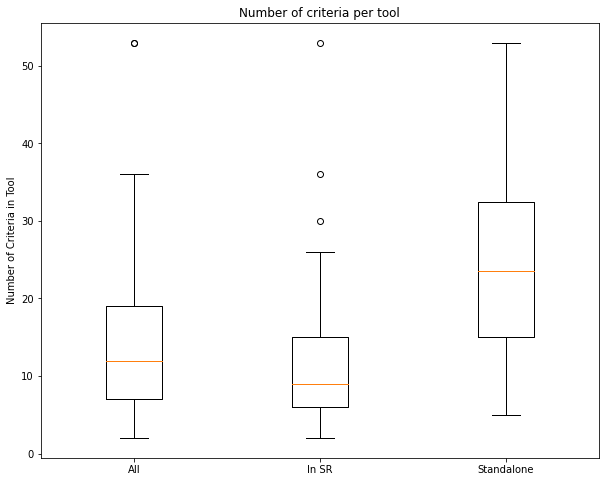

In [6]:

review_tools = tools[tools['is_sr']]
non_review_tools = tools[tools['is_sr'] == False]


plt.boxplot([tools['num_criteria'], review_tools['num_criteria'], non_review_tools['num_criteria']])
plt.title("Number of criteria per tool")
plt.xticks([1,2,3], ['All', 'In SR', 'Standalone'])
plt.ylabel("Number of Criteria in Tool")
print(f"Median: {tools['num_criteria'].median()}")

## Figure 3
Counts of criteria by heading

Text(0, 0.5, 'Top-level Category Code')

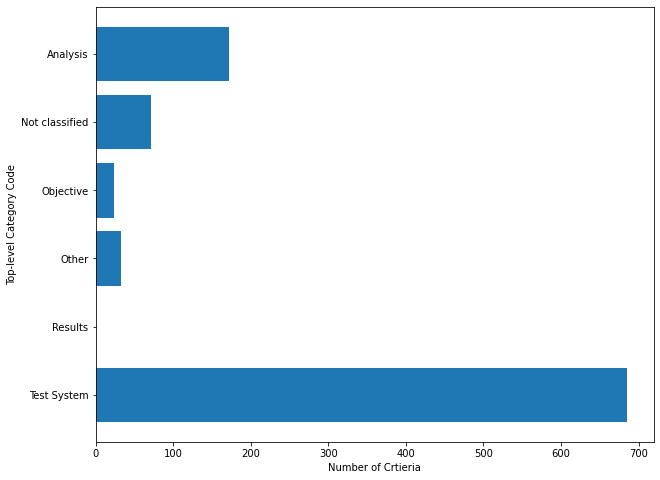

In [7]:
headings_lv1 = sorted(raw['1st Level Code'].unique(), reverse=True)
counts_lv1 = [sum(raw['1st Level Code'] == h) for h in headings_lv1]

plt.barh(headings_lv1, counts_lv1)
plt.xlabel("Number of Crtieria")
plt.ylabel("Top-level Category Code")

Text(0, 0.5, 'Category Code (lv1:lv2)')

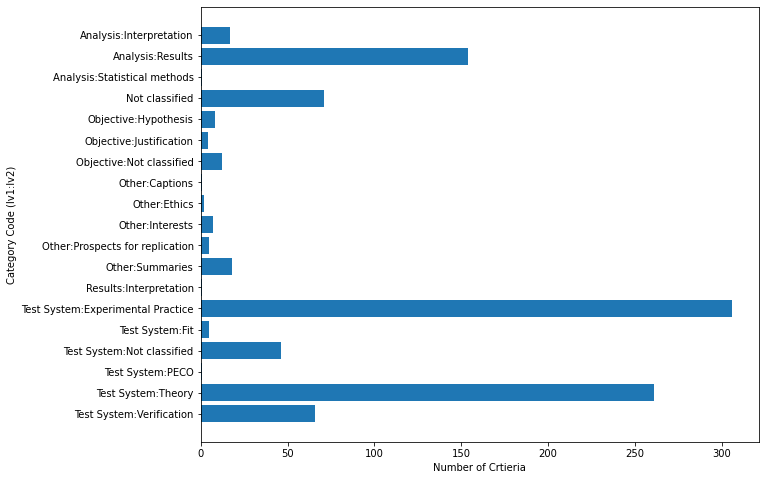

In [8]:
headings_lv2 = sorted(raw['Heading_12'].unique(), reverse=True)
counts_lv2 = [sum(raw['Heading_12'] == h) for h in headings_lv2]

plt.barh(headings_lv2, counts_lv2)
plt.xlabel("Number of Crtieria")
plt.ylabel("Category Code (lv1:lv2)")

## Criteria Coverage (count >0)
For top-level, 2nd level, 4th level headings: count the number of tools that have one criterion in this heading

Text(0, 0.5, 'Category Code')

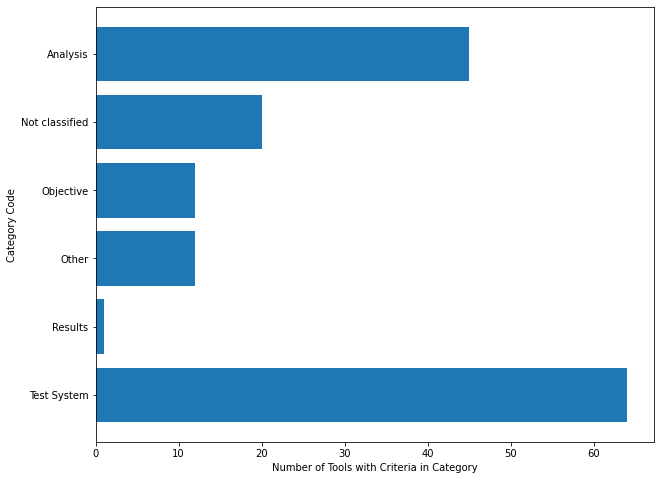

In [9]:
headings_lv1 = sorted(raw['1st Level Code'].unique(), reverse=True)
counts_lv1 = [0] * len(headings_lv1)

for tid in tools['Tool ID']:
    #print(f"-> {tid}")
    headings = raw[raw['Tool ID'] == tid]['1st Level Code'].unique()
    for i, h in enumerate(headings_lv1):
        #print(f"[{i}] // {h} // {headings}")
        if h in headings:
            counts_lv1[i] += 1
    #print(f"-> {counts_lv1}")
    
plt.barh(headings_lv1, counts_lv1)
plt.xlabel("Number of Tools with Criteria in Category")
plt.ylabel("Category Code")

Text(0, 0.5, 'Category Code (lv1:lv2)')

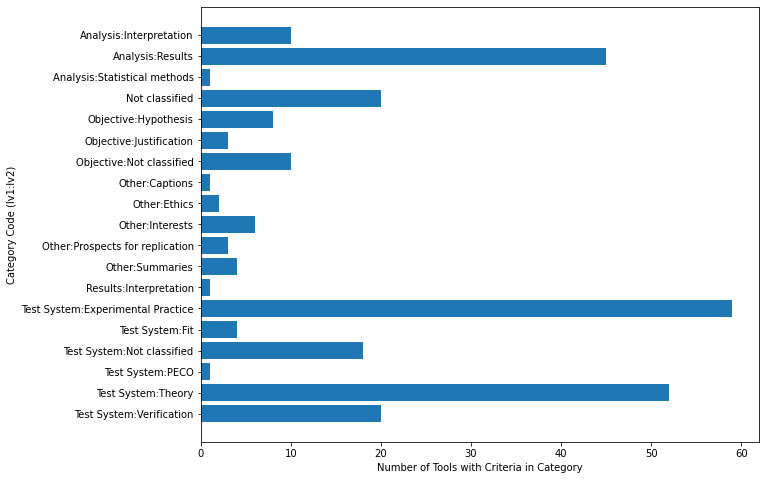

In [10]:
headings_lv2 = sorted(raw['Heading_12'].unique(), reverse=True)
counts_lv2 = [0] * len(headings_lv2)

for tid in tools['Tool ID']:
    #print(f"-> {tid}")
    headings = raw[raw['Tool ID'] == tid]['Heading_12'].unique()
    for i, h in enumerate(headings_lv2):
        #print(f"[{i}] // {h} // {headings}")
        if h in headings:
            counts_lv2[i] += 1
    #print(f"-> {counts_lv1}")
    
plt.barh(headings_lv2, counts_lv2)
plt.xlabel("Number of Tools with Criteria in Category")
plt.ylabel("Category Code (lv1:lv2)")

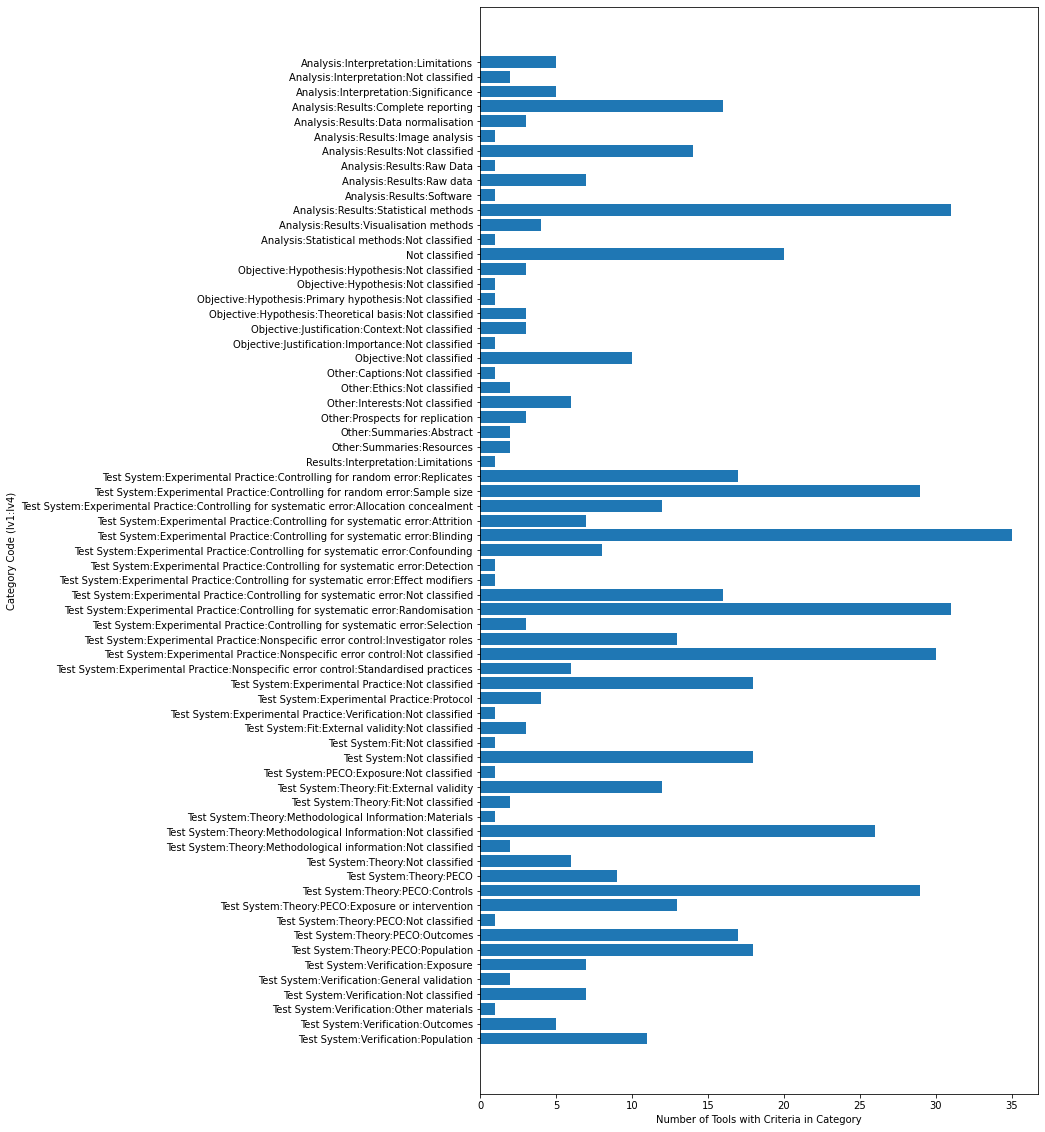

In [11]:
headings_lv4 = sorted(raw['Heading'].unique(), reverse=True)
counts_lv4 = [0] * len(headings_lv4)

for tid in tools['Tool ID']:
    #print(f"-> {tid}")
    headings = raw[raw['Tool ID'] == tid]['Heading'].unique()
    for i, h in enumerate(headings_lv4):
        #print(f"[{i}] // {h} // {headings}")
        if h in headings:
            counts_lv4[i] += 1
    #print(f"-> {counts_lv1}")
    
plt.rcParams["figure.figsize"] = (10,20)
plt.barh(headings_lv4, counts_lv4)
plt.xlabel("Number of Tools with Criteria in Category")
plt.ylabel("Category Code (lv1:lv4)")
plt.rcParams["figure.figsize"] = (10,8)

## Figure 6 --- Normalised Criteria Counts
_unique_ criteria counts for each tool, divided by total criteria for that tool

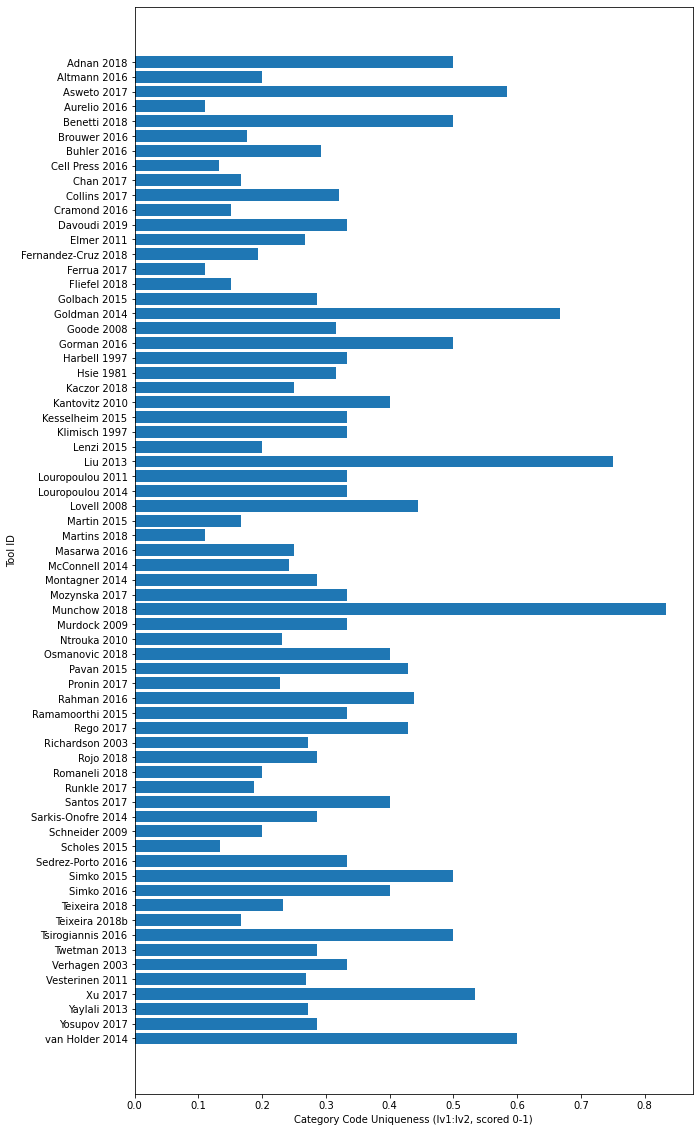

In [12]:
tool_names = sorted(tools['Tool ID'], reverse=True)
heading_uniqueness_score = []
for tid in tool_names:
    row = tools[tools['Tool ID'] == tid].iloc[0]

    #print(f"-> {row['count_unique_headings']}")
    heading_uniqueness_score.append(row['count_unique_headings_12'] / row['num_criteria'])

plt.rcParams["figure.figsize"] = (10,20)
plt.barh(tool_names, heading_uniqueness_score)
plt.xlabel("Category Code Uniqueness (lv1:lv2, scored 0-1)")
plt.ylabel("Tool ID")
plt.rcParams["figure.figsize"] = (10,8)


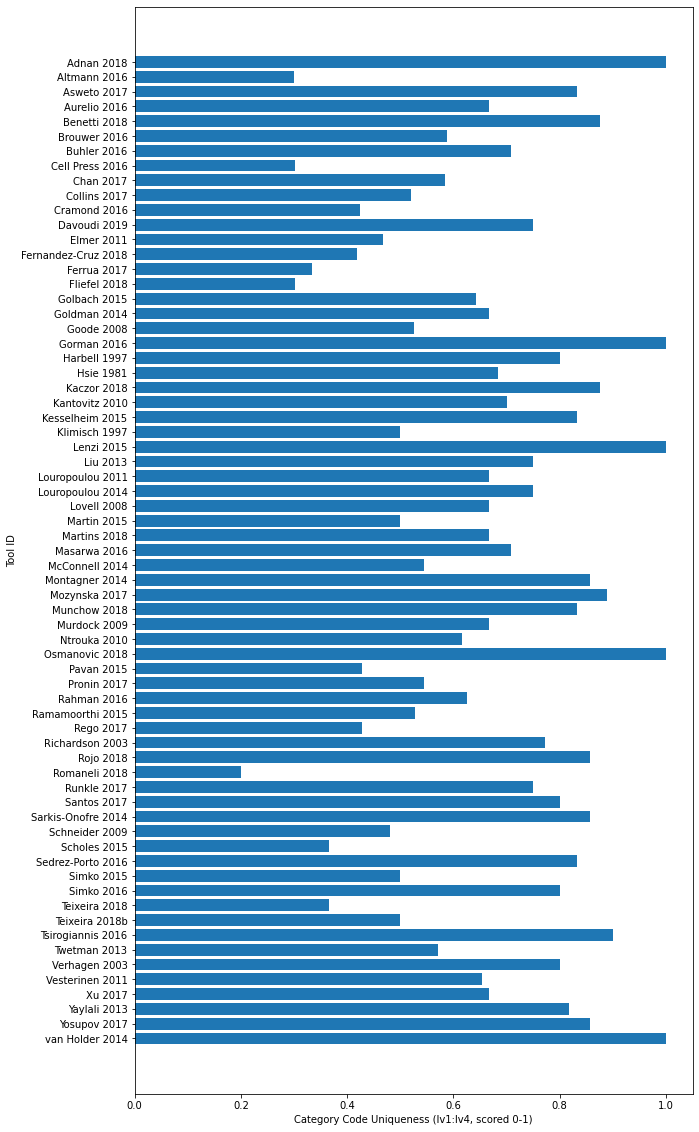

In [13]:
tool_names = sorted(tools['Tool ID'], reverse=True)
heading_uniqueness_score = []
for tid in tool_names:
    row = tools[tools['Tool ID'] == tid].iloc[0]
    
    #print(f"-> {row['count_unique_headings']}")
    heading_uniqueness_score.append(row['count_unique_headings'] / row['num_criteria'])

plt.rcParams["figure.figsize"] = (10,20)
plt.barh(tool_names, heading_uniqueness_score)
plt.xlabel("Category Code Uniqueness (lv1:lv4, scored 0-1)")
plt.ylabel("Tool ID")
plt.rcParams["figure.figsize"] = (10,8)

## Figure 7
Counts for how many criteria there are in 1, 2nd level headings

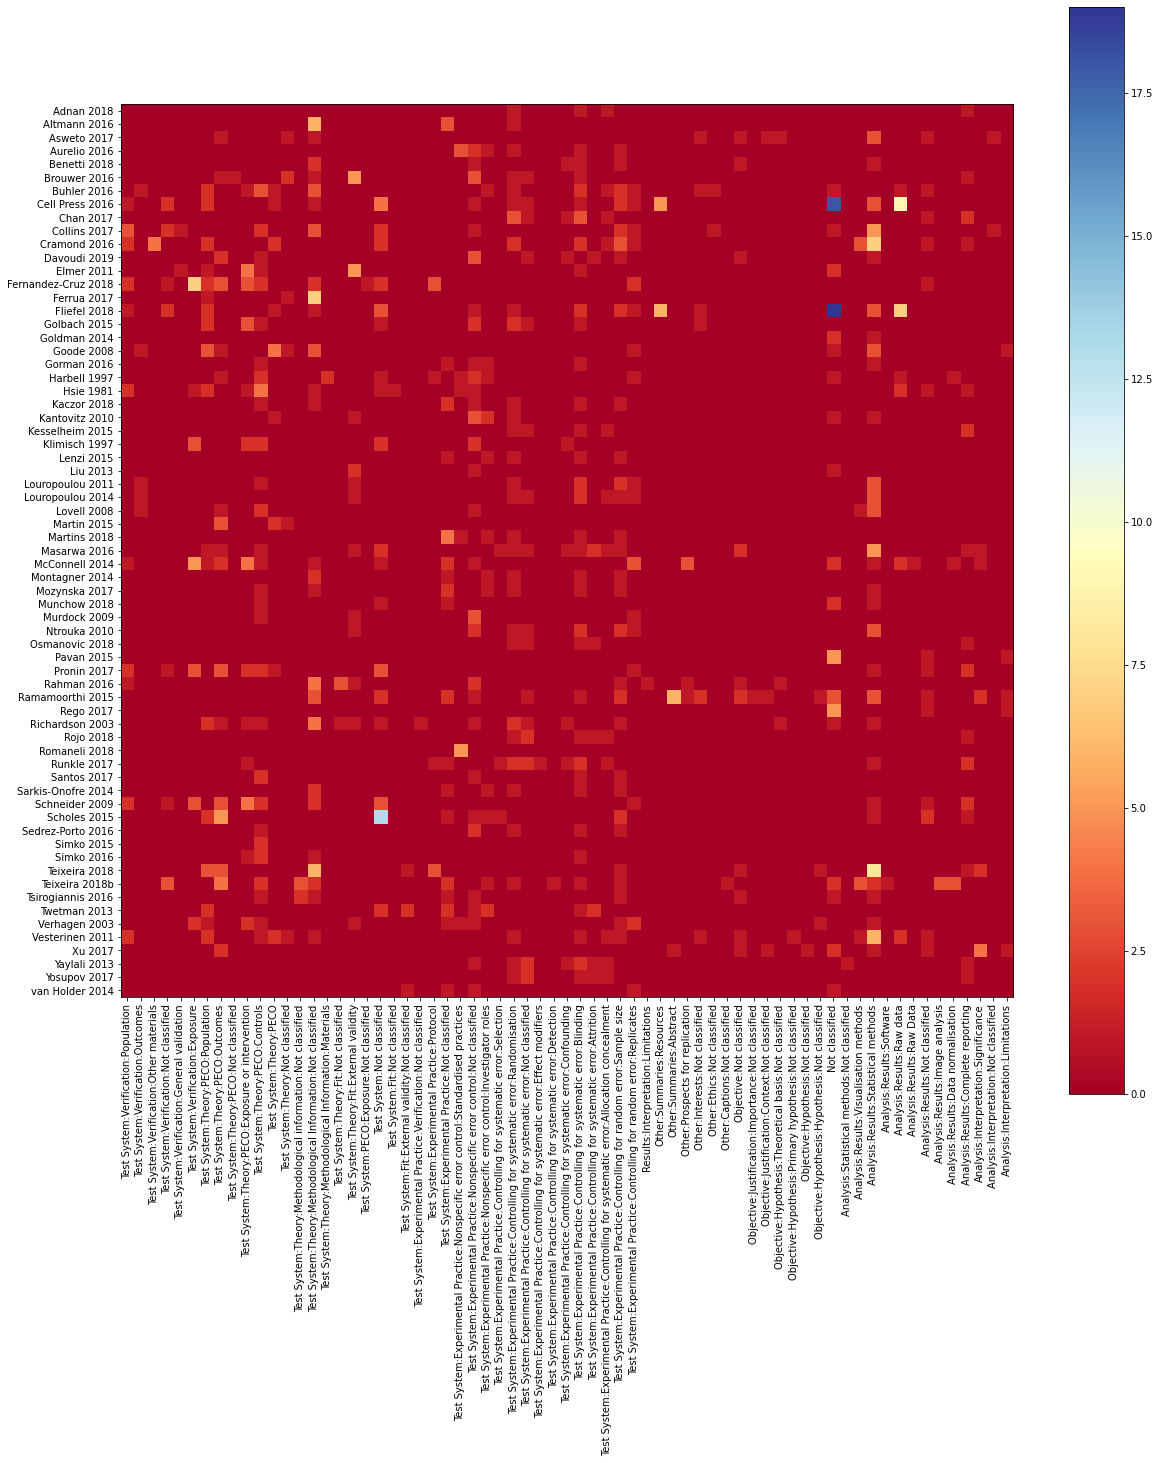

In [52]:
# Build a list of headings
headings_all = sorted(raw['Heading'].unique(), reverse=True)
tool_ids = sorted(tools['Tool ID'])
counts_by_tool = {tid: {h: 0 for h in headings_all} for tid in tool_ids}


for i, row in raw.iterrows():
    counts_by_tool[row['Tool ID']][row['Heading']] += 1

matrix = []
for tid in tool_ids:
    row = []
    for h in headings_all:
        row.append(counts_by_tool[tid][h])
        
    #print(f"-> {row}")
    matrix.append(row)

df = pd.DataFrame(matrix, columns=headings_all, index=tool_ids)

plt.rcParams["figure.figsize"] = (20,20)
plt.imshow(df, cmap="RdYlBu")
plt.colorbar() 
plt.xticks(range(len(df.columns)), df.columns, rotation=90) 
plt.yticks(range(len(df.index)), df.index)
plt.show()
plt.rcParams["figure.figsize"] = (10,8)

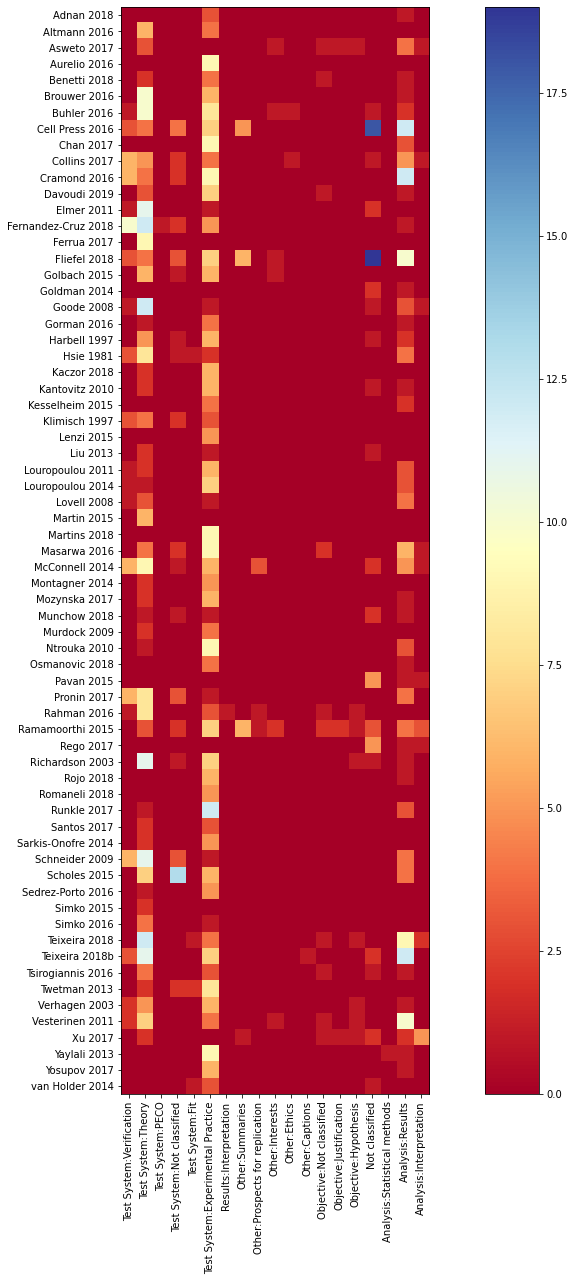

In [53]:
# Build a list of headings
headings_12 = sorted(raw['Heading_12'].unique(), reverse=True)
tool_ids = sorted(tools['Tool ID'])
counts_by_tool = {tid: {h: 0 for h in headings_12} for tid in tool_ids}


for i, row in raw.iterrows():
    counts_by_tool[row['Tool ID']][row['Heading_12']] += 1

matrix = []
for tid in tool_ids:
    row = []
    for h in headings_12:
        row.append(counts_by_tool[tid][h])
        
    #print(f"-> {row}")
    matrix.append(row)

df = pd.DataFrame(matrix, columns=headings_12, index=tool_ids)

plt.rcParams["figure.figsize"] = (20,20)
plt.imshow(df, cmap="RdYlBu")
plt.colorbar() 
plt.xticks(range(len(df.columns)), df.columns, rotation=90) 
plt.yticks(range(len(df.index)), df.index)
plt.show()
plt.rcParams["figure.figsize"] = (10,8)
#df